In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc, cost_functions
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [ ]:
wc = WCModel()
dur = 2000
wc.params['duration'] = dur

control0 = np.zeros(dur*10+1)
control0[:1000] = 5.
control0[10000:11000] = -5.

ones = np.ones(dur*10+1)

In [ ]:
step = 0.05

exc_inputs = np.around(np.arange(0., 7.1, step), 3)
inh_inputs = np.around(np.arange(0., 5.1, step), 3)

limit_std_osc = 1e-2
limit_mean_osc = 1e-1
limit_down = 0.15

up = []
down = []
osc = []
bi = []

for i in inh_inputs:
    for e in exc_inputs:
    
        wc.params['exc_ext'] = e * ones + control0
        wc.params['inh_ext'] = i * ones
        wc.run()

        mean_std_0 = [np.mean(wc.exc[0,9000:9999]), np.std(wc.exc[0,9000:9999])]
        mean_std_1 = [np.mean(wc.exc[0,-1000:]), np.std(wc.exc[0,-1000:])]

        if mean_std_0[1] < limit_std_osc:    # first state steady
            if mean_std_1[1] < limit_std_osc:    # second state steady
                if np.abs(mean_std_0[0] - mean_std_1[0]) < limit_std_osc:   # same steady state
                    if mean_std_0[0] < limit_down:
                        #print("down state")
                        down.append([e, i])
                    elif mean_std_0[0] >= limit_down:
                        #print("up state")
                        up.append([e, i])
                else:   # bistable
                    #print("bistable state")
                    bi.append([e, i])
            else:
                print("first steady, second ?", e,i)
                plt.plot(wc.t, wc.exc[0,:])
                plt.show()
        else:       # first state osc
            if np.abs(mean_std_0[0] - mean_std_1[0]) < limit_mean_osc:   # same oscillation
                #print("oscillatory state")
                osc.append([e,i])

            else:
                print("oscillation with different mean?", e,i)
                plt.plot(wc.t, wc.exc[0,:])
                plt.show()

print(len(osc)+len(up)+len(down)+len(bi))
print(len(exc_inputs)*len(inh_inputs))

In [4]:
def evaluateSimulation(traj):
    model = search.getModelFromTraj(traj)
    model.randomICs()
    defaultDuration = model.params['duration']
      
    model.params['duration'] = defaultDuration
    
    rect_stimulus = stim.RectifiedInput(amplitude=0.4).to_model(model)
    exc_ext =  model.params['exc_ext']
    #print("e ext, I ext = ", model.params.exc_ext, model.params.inh_ext)
    
    model.params['exc_ext'] = rect_stimulus * 5.0 + exc_ext
    model.run()

    #plt.plot(model.t, model.exc[0,:])
    #plt.show()
    
    state_length = 2000
    down_window = (defaultDuration/2-state_length<model.t) & (model.t<defaultDuration/2)
    up_window = (defaultDuration-state_length<model.t) & (model.t<defaultDuration)
    up_state_rate = np.mean(model.output[:, up_window], axis=1)
    down_state_rate = np.mean(model.output[:, down_window], axis=1)
    up_down_difference = np.max(up_state_rate - down_state_rate)
        
    max_amp_output = np.max(
          np.max(model.output[:, up_window], axis=1) 
        - np.min(model.output[:, up_window], axis=1)
    )
    max_output = np.max(model.output[:, up_window])
     
    model_frs, model_pwrs = func.getMeanPowerSpectrum(model.output, dt=model.params.dt, maxfr=40, spectrum_windowsize=10)
    max_power = np.max(model_pwrs)     
    
    model_frs, model_pwrs = func.getMeanPowerSpectrum(model.output[:, up_window], dt=model.params.dt, maxfr=40, spectrum_windowsize=5)
    domfr = model_frs[np.argmax(model_pwrs)]    

    result = {
        "end" : 3,
        "max_output": max_output, 
        "max_amp_output" : max_amp_output,
        "max_power" : max_power,
        "domfr" : domfr,
        "up_down_difference" : up_down_difference
    }
    
    search.saveToPypet(result, traj)
    return 

In [5]:
model = WCModel()

model.params['dt'] = 0.1 # Integration time step, ms
model.params['duration'] = 20 * 1000 # Simulation time, ms
model.params['save_dt'] = 10.0 # 10 ms sampling steps for saving data, should be multiple of dt
model.params["exc_ext"] = 0.
model.params["inh_ext"] = 0.

In [6]:
from neurolib.optimize.exploration import BoxSearch
from neurolib.utils.parameterSpace import ParameterSpace
import neurolib.utils.stimulus as stim
import neurolib.utils.functions as func
import neurolib.optimize.exploration.explorationUtils as eu

parameters = ParameterSpace({"exc_ext": np.linspace(0.0, 4.0, 17), 
                             "inh_ext": np.linspace(0., 3., 13)
                             }, kind="grid")

search = BoxSearch(evalFunction = evaluateSimulation, model=model, parameterSpace=parameters, filename='wc-bifurcation-diagram.hdf')

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/wc-bifurcation-diagram.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 221
MainProcess root INFO     BoxSearch: Environment initialized.


In [7]:
search.run()

MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2023-03-09-14H-43M-11S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2023-03-09-14H-43M-11S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2023-03-09-14H-43M-11S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2023-03-09-14H-43M-11S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `resu

In [6]:
search.loadResults(all=False)

MainProcess root INFO     Loading results from ./data/hdf/wc-bifurcation-diagram.hdf
MainProcess root INFO     Analyzing trajectory results-2023-02-16-15H-25M-59S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/wc-bifurcation-diagram.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2023-02-16-15H-25M-59S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Aggregating results to `dfResults` ...
100%|██████████| 221/221 [00:01<00:00, 177.04it/s]
MainProcess root INFO     All results loaded.


In [8]:
comp_points = [[1., 0.5], [2.8, 1.6], [3., 0.5], [2., 0.5]]

In [10]:
plot_key_label = "Max. $E$"
eu.plotExplorationResults(search.dfResults, 
                          par1=['exc_ext', '$u_E^{ext}$'], 
                          par2=['inh_ext', '$u_I^{ext}$'], 
                          plot_key='max_output',
                          plot_clim=[0.0, 1.0],
                          nan_to_zero=False,
                          plot_key_label=plot_key_label, 
                          one_figure=False,
                          contour=["max_amp_output", "up_down_difference"],
                          contour_color=[['white'], ['springgreen']],
                          contour_levels=[[10], [0.1]],
                          contour_alpha=[1.0, 1.0],
                          contour_kwargs={0 : {"linewidths" : (1,)}, 1 : {"linestyles" : "--", "linewidths" : (1,)}},
                          mask_threshold=0.1,
                          mask_alpha=0.2,
                          points=comp_points,
                          )

AttributeError: 'BoxSearch' object has no attribute 'dfResults'

In [388]:
model = WCModel()

dt = 0.1
model.params['dt'] = dt # Integration time step, ms
model.params['duration'] = 1. * 1000 # Simulation time, ms
model.params["exc_ext"] = 2.
model.params["inh_ext"] = 0.5

model.run()

peaks = scipy.signal.find_peaks(model.exc[0,100:])[0]
plist = []
for pind in range(1, len(peaks)):
    plist.append(model.params.dt * (peaks[pind]-peaks[pind-1]))

period = np.around(np.mean(plist),1)
print("target oscillation period = ", period)

MainProcess root INFO     wc: Model initialized.


target oscillation period =  15.7


In [389]:
duration = 300.
model.params.duration = duration
zero_input = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
controlmat = np.zeros((1,2))
controlmat[0,0] = 1.


In [390]:
results = dict()
w2_array = [1e-2, 1e-3, 1e-4, 1e-5]
proms = [0.01, 0.03, 0.1, 0.3]

results["task"] = ["FF_up", "FF_bi", "FF_down", "FF_osc", "P_up", "P_bi", "P_down", "P_osc", "AC_up", "AC_bi", "AC_down", "AC_osc"]
results["periods"] = [ [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ],
                       [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ] ]
results["controls"] =  [ [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ],
                       [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ] ]

241


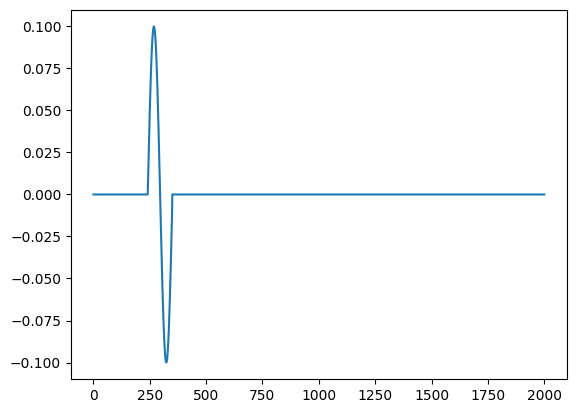

In [391]:
amp = 1e-1
target_period = 0.7*period
int0 = int(2000 - (16. * target_period / model.params.dt))
print(int0)

def getinit(shape):
    inp_ = np.zeros((shape))
    for t in range(int0, int0+int(1*target_period / model.params.dt)):
        inp_[0,0,t] = amp * np.sin(2.*np.pi*dt*(t-int0)/target_period)

    return inp_

plt.plot(getinit( (1,2,2001) )[0,0,:])
plt.show()

def getperiods(xs, pr=0.01):
    peaks = scipy.signal.find_peaks(xs, prominence=pr)[0]
    periods = []
    for i in range(1, len(peaks)):
        periods.append((peaks[i] - peaks[i-1])*dt)

    print(periods)

    return periods

# Fourier, phase, and auto-correlation cost at four different points, with different weights

--------------------------------
--------------------------------
--------------------------------
POINT :  [1.0, 0.5]
Target period =  10.989999999999998
--------------------------------
--------------------------------
--------------------------------
POINT :  [2.8, 1.6]
Target period =  10.989999999999998
--------------------------------
--------------------------------
--------------------------------
POINT :  [3.0, 0.5]
Target period =  10.989999999999998
--------------------------------
--------------------------------
--------------------------------
POINT :  [2.0, 0.5]
Target period =  10.989999999999998
--------------------------------
FOURIER COST
Optimal control with target oscillation period
L2 cost weight =  0.01
Compute control for a deterministic system
Cost in iteration 0: -0.40401326149285177
Cost in iteration 50: -0.4054632105360152
Cost in iteration 100: -0.40659709294547114
Cost in iteration 150: -0.4075399380224449
Cost in iteration 200: -0.40831050221186477
Cost i

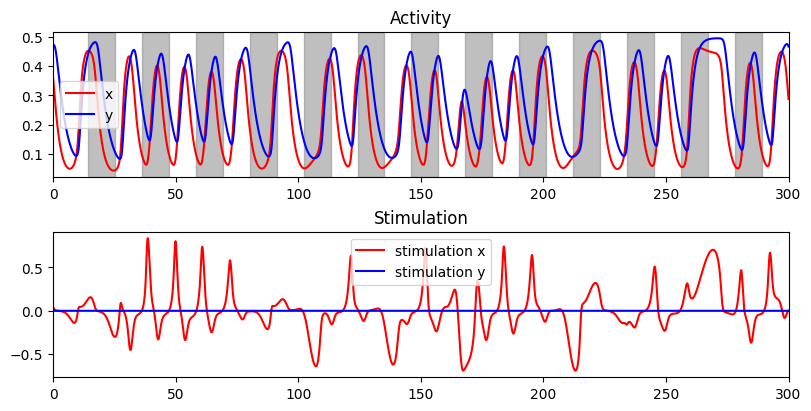

Optimal control with target oscillation period
L2 cost weight =  0.001
Compute control for a deterministic system
Cost in iteration 0: -0.7288473423628449
Cost in iteration 50: -0.7289317246228789
Cost in iteration 100: -0.7289849498107297
Cost in iteration 150: -0.7290239907154143
Cost in iteration 200: -0.7290575191414621
Cost in iteration 250: -0.7290804852652573
Cost in iteration 300: -0.7290948398834349
Cost in iteration 350: -0.7291183444624302
Cost in iteration 400: -0.7291386559118819
Final cost : -0.7291386559118819
[11.4, 11.600000000000001, 12.0, 12.0, 11.5, 11.100000000000001, 10.700000000000001, 10.3, 10.0, 10.4, 10.600000000000001, 10.8, 10.8, 10.600000000000001, 10.3, 10.0, 10.3, 10.600000000000001, 11.0, 11.4, 11.700000000000001, 12.100000000000001, 11.9, 12.5]


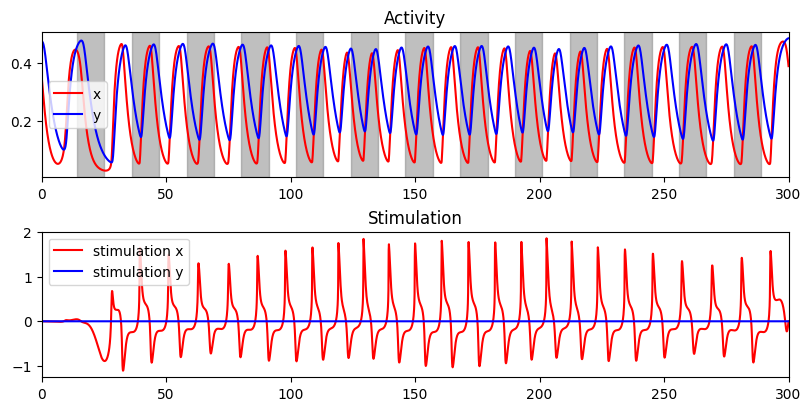

Optimal control with target oscillation period
L2 cost weight =  0.0001
Compute control for a deterministic system
Cost in iteration 0: -0.7677108239087821
Cost in iteration 50: -0.7677569457184793
Cost in iteration 100: -0.7677853367706263
Cost in iteration 150: -0.767804689363561
Cost in iteration 200: -0.7678244228982918
Cost in iteration 250: -0.7678474521808296
Cost in iteration 300: -0.7678710531380605
Cost in iteration 350: -0.7678893024245907
Cost in iteration 400: -0.7679011154779968
Final cost : -0.7679011154779968
[11.100000000000001, 11.600000000000001, 14.8, 11.4, 11.100000000000001, 10.9, 10.700000000000001, 10.5, 10.5, 10.600000000000001, 10.8, 11.100000000000001, 11.4, 11.700000000000001, 11.600000000000001, 11.5, 11.3, 11.3, 11.200000000000001, 16.2, 11.3, 11.200000000000001, 12.0]


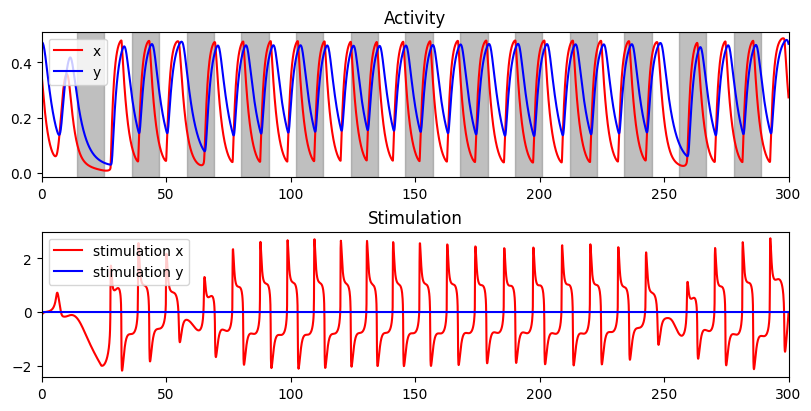

Optimal control with target oscillation period
L2 cost weight =  1e-05
Compute control for a deterministic system
Cost in iteration 0: -0.7919911773749825
Cost in iteration 50: -0.7919911775759716
Cost in iteration 100: -0.791991177725456
Cost in iteration 150: -0.7919911778530311
Cost in iteration 200: -0.7919911779749775
Cost in iteration 250: -0.7919911781014726
Cost in iteration 300: -0.7919911782493942
Cost in iteration 350: -0.7919911784280043
Cost in iteration 400: -0.7919911786811402
Final cost : -0.7919911786811402
[11.100000000000001, 11.3, 15.8, 11.100000000000001, 11.0, 10.9, 10.8, 10.600000000000001, 10.5, 10.5, 10.700000000000001, 11.0, 11.4, 11.600000000000001, 11.700000000000001, 11.600000000000001, 11.4, 11.4, 11.5, 13.0, 13.4, 11.3]


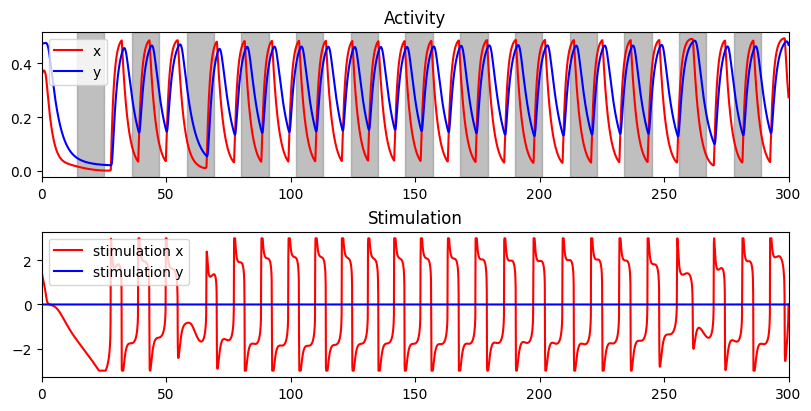

--------------------------------
PHASE COST
--------------------------------
AUTO CORRELATION COST


In [414]:
it = 400
pr = np.arange(0,1001,50)
maxstr = 3.
proms = [0.001, 0.003, 0.1, 0.3]


for pind in range(len(comp_points)):
    p = comp_points[pind]
    print("--------------------------------")
    print("--------------------------------")
    print("--------------------------------")
    print("POINT : ", p)
    print("Target period = ", target_period)

    if pind not in [3]:
        continue

    initinp = getinit(zero_control.shape)

    model.params["exc_ext"] = zero_input + p[0]
    model.params["inh_ext"] = zero_input + p[1]
    model.run()
    
    model.params.exc_init = np.array([[ model.exc[0,-1] ]])
    model.params.inh_init = np.array([[ model.inh[0,-1] ]])

    print("--------------------------------")
    print("FOURIER COST")

    for iw in range(len(w2_array)):
        w2 = w2_array[iw]

        #break

        if iw not in [0,1,2,3]:
            continue


        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), control_matrix = controlmat, )
        model_controlled.maximum_control_strength = maxstr
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_f"] = 1.
        model_controlled.weights["w_2"] = w2
        print("L2 cost weight = ", w2)

        if type(results["controls"][pind][iw]) != type(None):
            model_controlled.control = results["controls"][pind][iw]
            model_controlled.update_input()

        model_controlled.optimize(it)
        results["periods"][pind][iw] = getperiods(model_controlled.get_xs()[0,0,int0:], proms[iw]) 
        results["controls"][pind][iw] = model_controlled.control.copy()

        plot_oc_singlenode(duration, model.params.dt, model_controlled.get_xs(), target_period, model_controlled.control,
                savepath=("./wc_ff_" + str(pind) + "_" + str(iw) + ".png") )

    print("--------------------------------")
    print("PHASE COST")

    for iw in range(len(w2_array)):
        w2 = w2_array[iw]

        break

        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), control_matrix = controlmat, )
        model_controlled.maximum_control_strength = maxstr
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_phase"] = 1.
        model_controlled.weights["w_2"] = w2
        print("L2 cost weight = ", w2)

        if type(results["controls"][pind+4][iw]) != type(None):
            model_controlled.control = results["controls"][pind+4][iw]
            model_controlled.update_input()
        else:
            model_controlled.control = initinp
            model_controlled.update_input()
        
        model_controlled.optimize(it)
        results["periods"][pind+4][iw] = getperiods(model_controlled.get_xs()[0,0,int0:], proms[iw]) 
        results["controls"][pind+4][iw] = model_controlled.control.copy()

        plot_oc_singlenode(duration, model.params.dt, model_controlled.get_xs(), target_period, model_controlled.control)


    print("--------------------------------")
    print("AUTO CORRELATION COST")

    for iw in range(len(w2_array)):
        w2 = w2_array[iw]

        break

        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), control_matrix = controlmat, )
        model_controlled.maximum_control_strength = maxstr
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_ac"] = 1.
        model_controlled.weights["w_2"] = w2
        print("L2 cost weight = ", w2)

        if type(results["controls"][pind+8][iw]) != type(None):
            model_controlled.control = results["controls"][pind+8][iw]
            model_controlled.update_input()
        else:
            model_controlled.control = initinp
            model_controlled.update_input()
        
        model_controlled.optimize(it)
        results["periods"][pind+8][iw] = getperiods(model_controlled.get_xs()[0,0,int0:]) 
        results["controls"][pind+8][iw] = model_controlled.control.copy()

        plot_oc_singlenode(duration, model.params.dt, model_controlled.get_xs(), target_period, model_controlled.control)

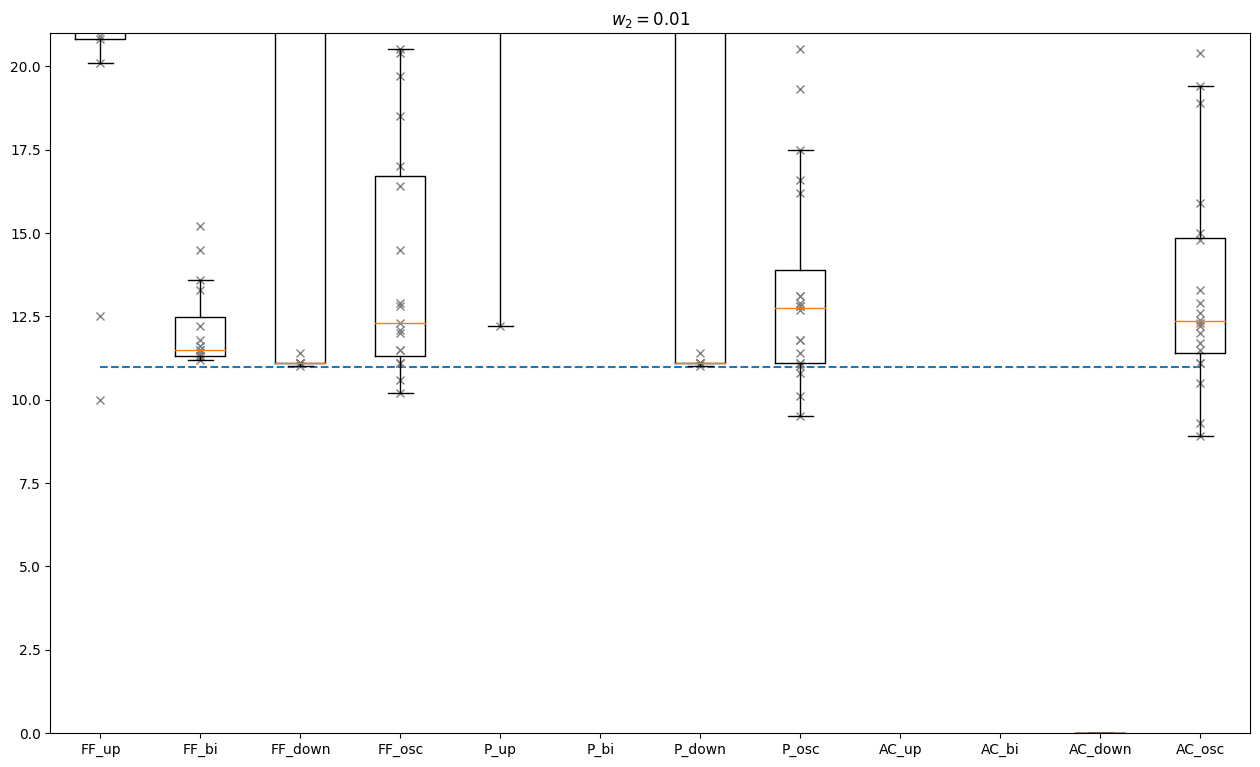

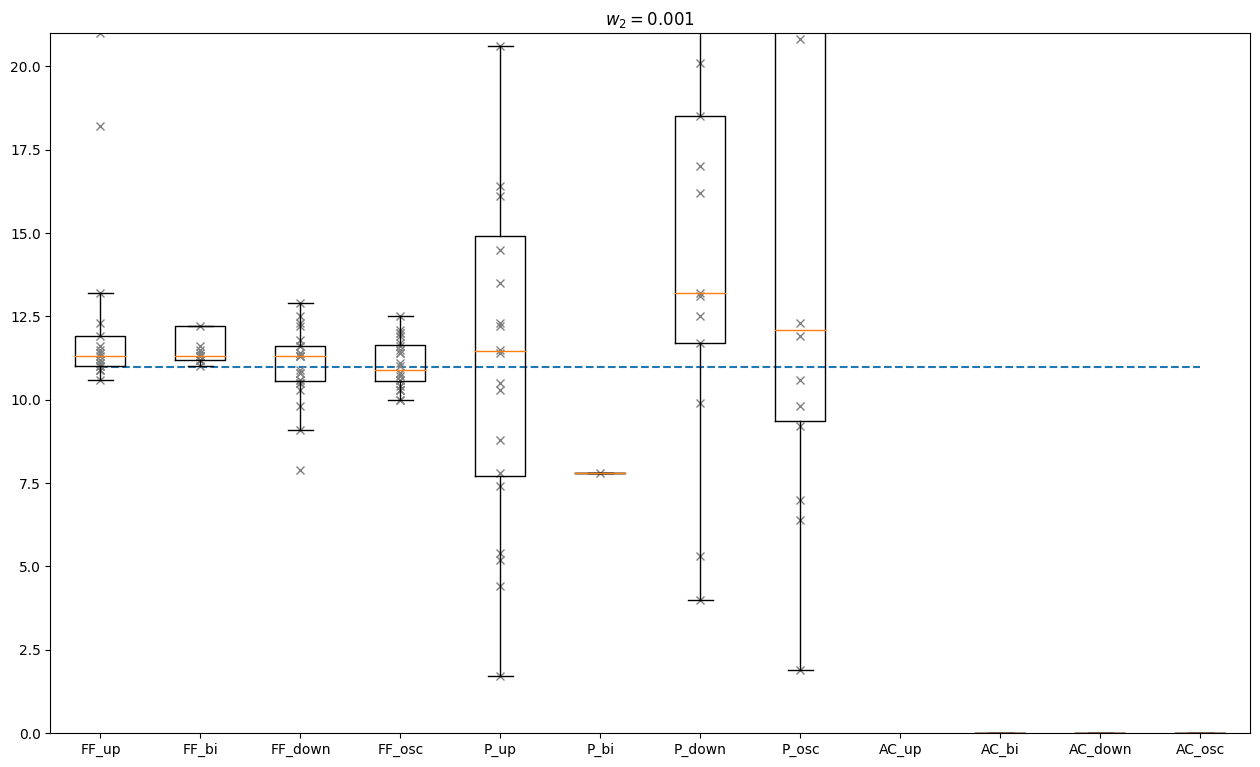

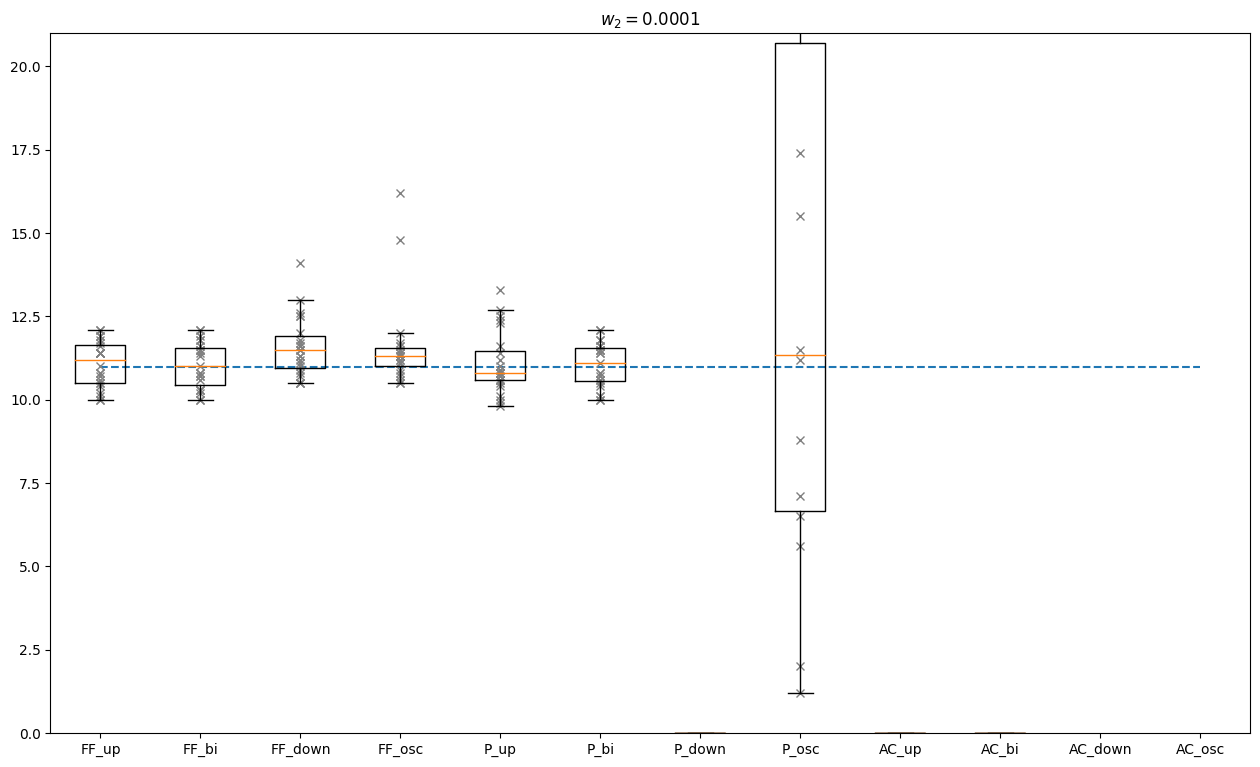

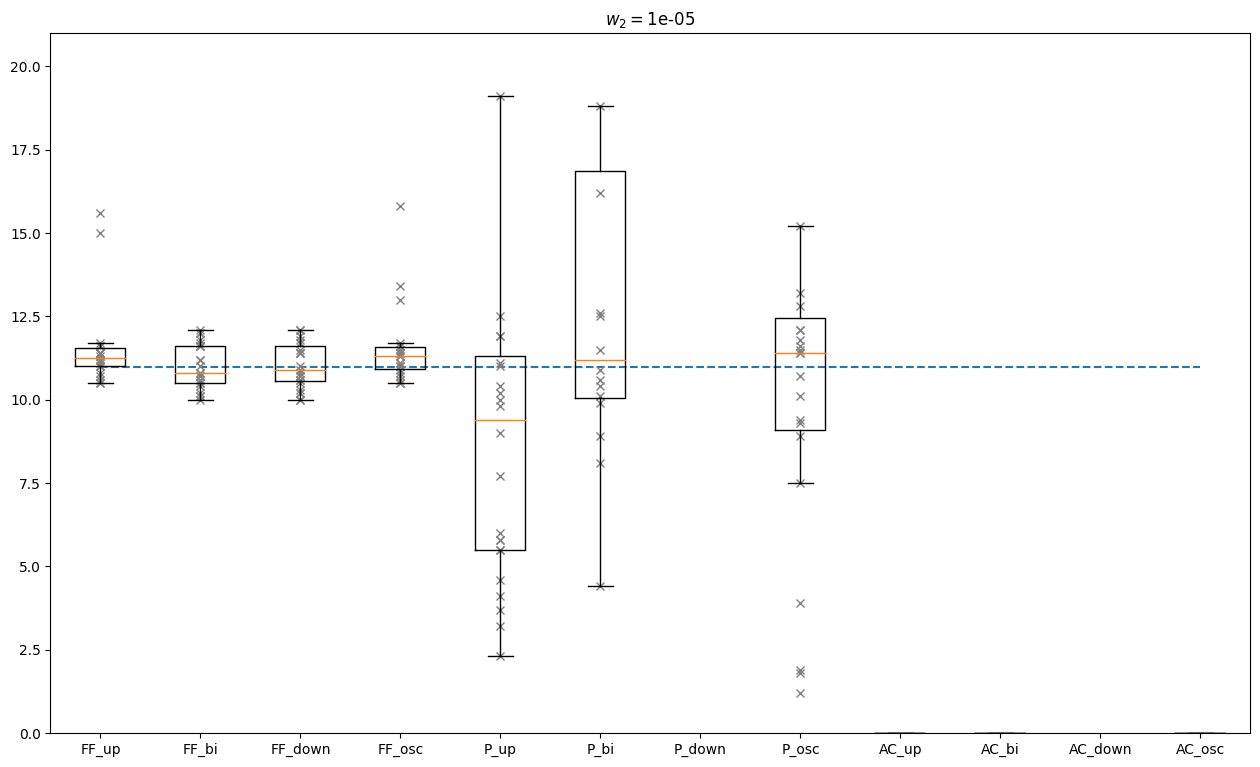

In [415]:
for iw in range(len(w2_array)):
    ydata = []
    fig = plt.figure(figsize =(12, 7))
    ax = fig.add_axes([0, 0, 1, 1])

    for i in range(12):
        if len(results["periods"][i][iw]) != 0:
            ydata.append(results["periods"][i][iw])
            for dpoint in results["periods"][i][iw]:
                ax.plot(i+1, dpoint, marker="x", color="grey")
        else:
            ydata.append([0])
            
    ax.boxplot(ydata, showfliers=False)
    ax.plot()
    ax.hlines(target_period, 1., 12., linestyle="--")
    ax.set_xticklabels(results["task"])
    ax.set_ylim(0., target_period+10)
    ax.set_title(r"$w_2 = $" + "{}".format(w2_array[iw]))
    plt.show()
    fig.savefig("wc_" + str(iw) + ".png", bbox_inches='tight')

In [416]:
results_xup = dict()
w2_array = [1e-1, 1e-2, 1e-3, 1e-4]
X_periods = [4, 8, 12, 16, 20]

results_xup["periods"] = [ [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ] ]
results_xup["controls"] =  [ [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ] ]

In [422]:
it = 1000
proms = [0.001, 0.03, 0.1, 0.3]

pind = 0
p = comp_points[pind]
print("--------------------------------")
print("POINT : ", p)

int0 = 100

for ix in range(len(X_periods)):
    duration = np.around(int0*dt + X_periods[ix] * target_period,0)
    print("duration = ", duration)

    model.params.duration = duration
    zero_input = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
    zero_control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]

    model.params["exc_ext"] = zero_input + p[0]
    model.params["inh_ext"] = zero_input + p[1]
    model.run()
    model.params.exc_init = np.array([[ model.exc[0,-1] ]])
    model.params.inh_init = np.array([[ model.inh[0,-1] ]])

    for iw in range(len(w2_array)):

        w2 =w2_array[iw]
        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), control_matrix = controlmat, )
        model_controlled.maximum_control_strength = maxstr
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_f"] = 1.
        model_controlled.weights["w_2"] = w2
        print("L2 cost weight = ", w2)

        if type(results_xup["controls"][ix][iw]) != type(None):
            model_controlled.control = results_xup["controls"][ix][iw]
            model_controlled.update_input()

        model_controlled.optimize(it)
        results_xup["periods"][ix][iw] = getperiods(model_controlled.get_xs()[0,0,int0:], proms[iw]) 
        results_xup["controls"][ix][iw] = model_controlled.control.copy()

        #plot_oc_singlenode(duration, model.params.dt, model_controlled.get_xs(), target_period, model_controlled.control, )
        #        savepath=("./wc_ff_" + str(pind) + "_" + str(iw) + ".png") )

--------------------------------
POINT :  [1.0, 0.5]
duration =  54.0
Optimal control with target oscillation period
L2 cost weight =  0.1
Compute control for a deterministic system
Cost in iteration 0: -0.0474766625285892
Converged in iteration 2 with cost -0.0474766625285892
Final cost : -0.0474766625285892
[12.600000000000001, 22.200000000000003]
Optimal control with target oscillation period
L2 cost weight =  0.01
Compute control for a deterministic system
Cost in iteration 0: -0.19633311134046433
Converged in iteration 2 with cost -0.19633311134046433
Final cost : -0.19633311134046433
[21.900000000000002, 11.5]
Optimal control with target oscillation period
L2 cost weight =  0.001
Compute control for a deterministic system
Cost in iteration 0: -0.339596342822424
Converged in iteration 8 with cost -0.339596342822424
Final cost : -0.339596342822424
[11.0, 11.0]
Optimal control with target oscillation period
L2 cost weight =  0.0001
Compute control for a deterministic system
Cost in 

In [420]:
import pickle
filehandler = open("results_xup.pickle","wb")
pickle.dump(results_xup,filehandler)


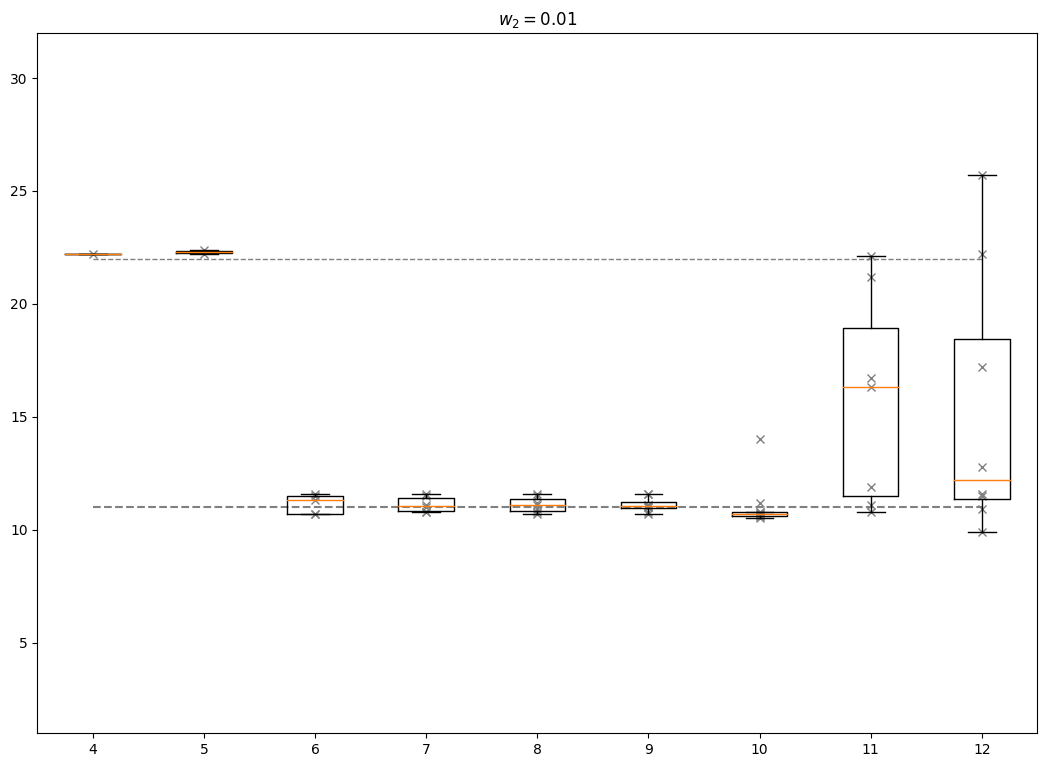

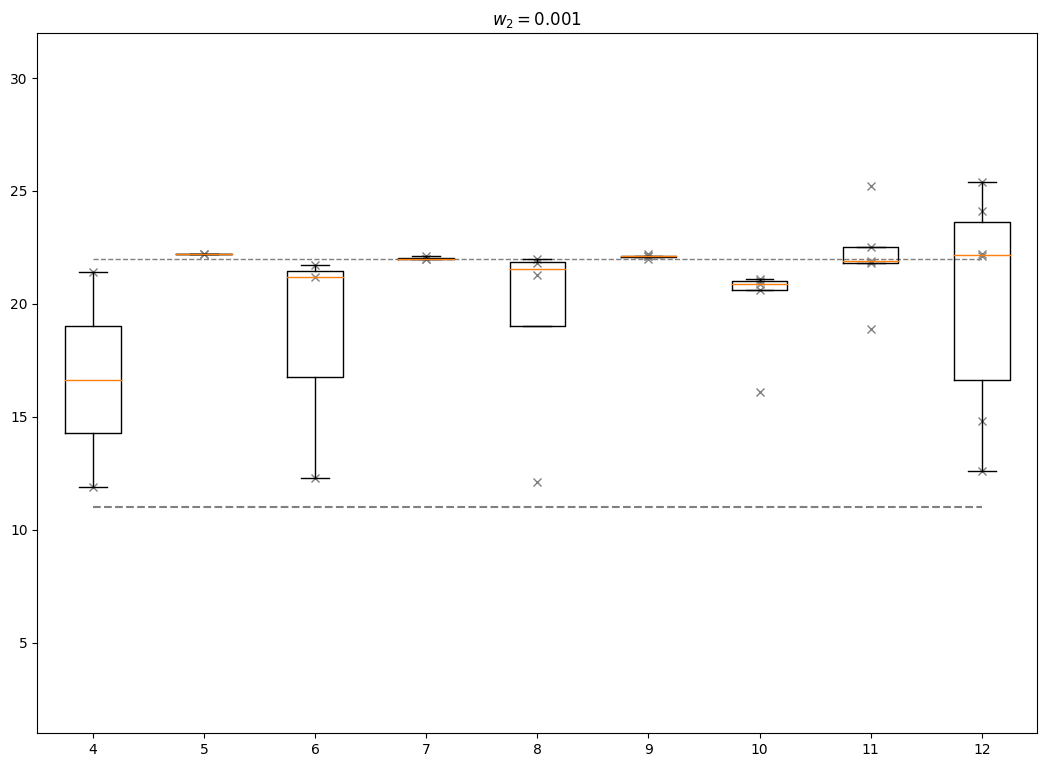

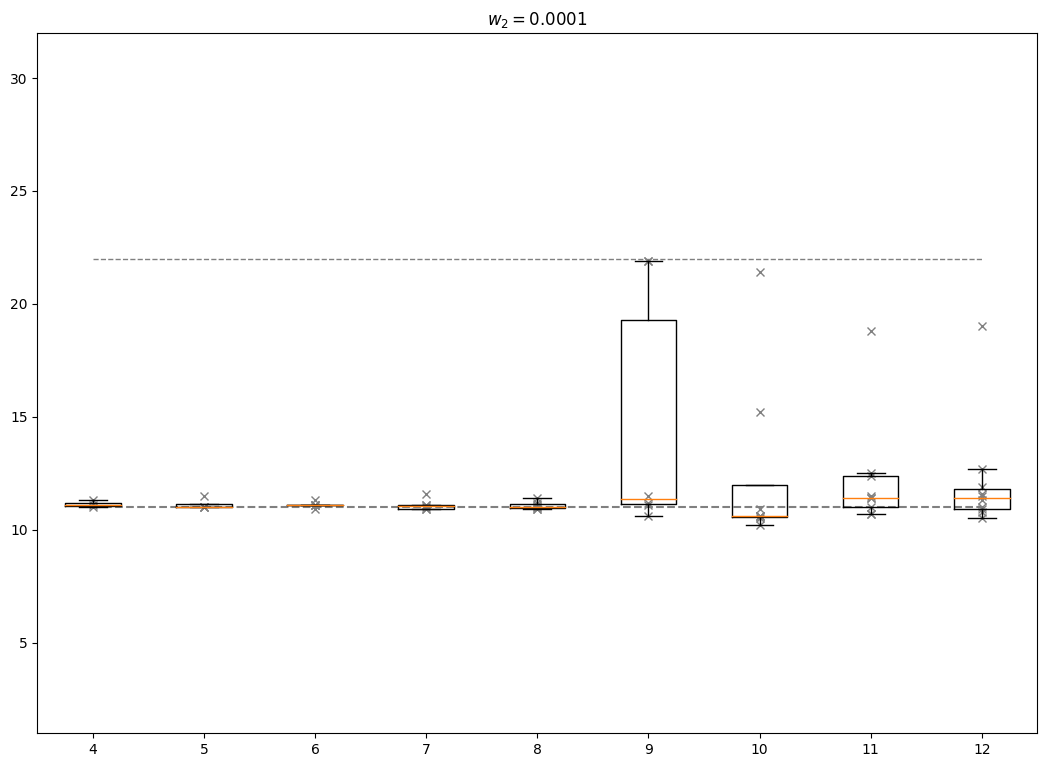

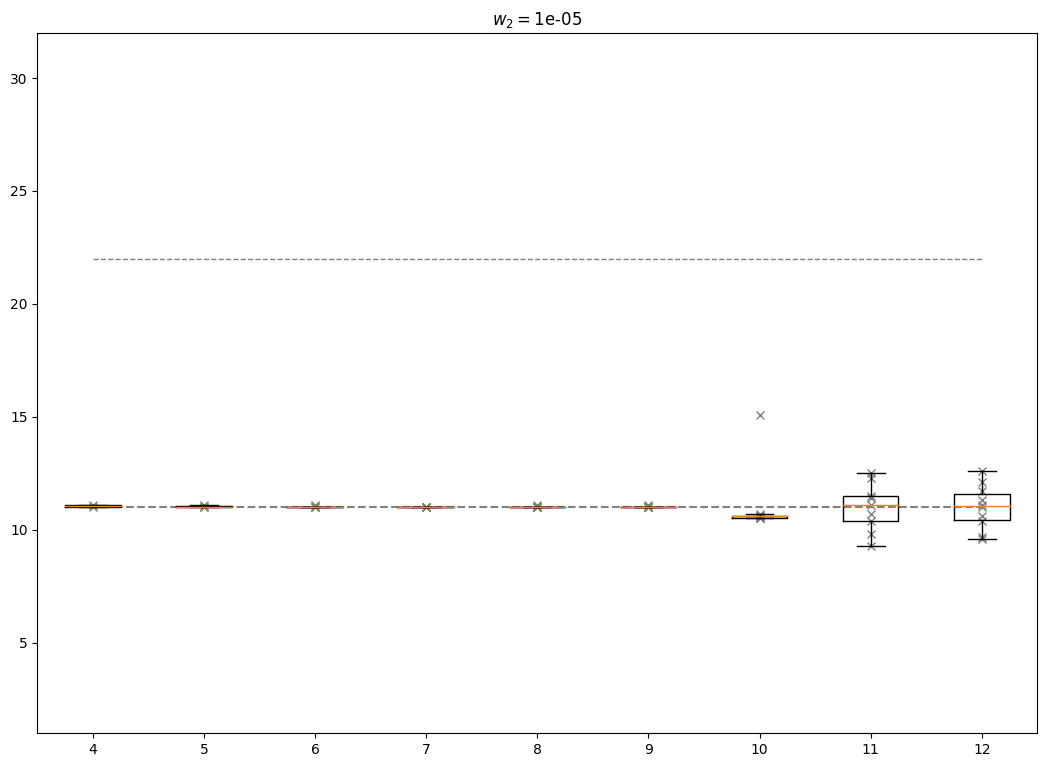

In [223]:
for iw in range(len(w2_array)):
    ydata = []
    fig = plt.figure(figsize =(10, 7))
    ax = fig.add_axes([0, 0, 1, 1])

    for i in range(len(results_xup["periods"])):
        if len(results_xup["periods"][i][iw]) != 0:
            ydata.append(results_xup["periods"][i][iw])
            for dpoint in results_xup["periods"][i][iw]:
                ax.plot(i+1, dpoint, marker="x", color="grey")
        else:
            ydata.append([0])

    #print(ydata)
            
    ax.boxplot(ydata, showfliers=False)
    ax.plot()
    ax.hlines(target_period, 1., 9., linestyle="--", color="gray")
    ax.hlines(2.*target_period, 1., 9., linestyle="--", color="gray", linewidth=1)
    ax.set_xticklabels(X_periods)
    ax.set_ylim(target_period-10, 2*target_period+10)
    ax.set_title(r"$w_2 = $" + "{}".format(w2_array[iw]))
    plt.show()
    fig.savefig("wc_xup_" + str(iw) + ".png", bbox_inches='tight')

In [224]:
results_xup1 = dict()
w2_array = [1e-1, 1e-3, 1e-5, 1e-7]
X_periods = [10, 20, 30]

results_xup1["periods"] = [ [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ]]
results_xup1["controls"] =  [ [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ]]

In [245]:
it = 200
proms = [0.001, 0.03, 0.1, 0.3]

pind = 0
p = comp_points[pind]
print("--------------------------------")
print("POINT : ", p)

int0 = 100

for ix in range(len(X_periods)):
    duration = np.around(int0*dt + X_periods[ix] * target_period,0)
    print("duration = ", duration)

    model.params.duration = duration
    zero_input = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
    zero_control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]

    model.params["exc_ext"] = zero_input + p[0]
    model.params["inh_ext"] = zero_input + p[1]
    model.run()
    model.params.exc_init = np.array([[ model.exc[0,-1] ]])
    model.params.inh_init = np.array([[ model.inh[0,-1] ]])

    for iw in range(len(w2_array)):

        if iw not in [3]:
            continue

        w2 =w2_array[iw]
        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), control_matrix = controlmat, )
        model_controlled.maximum_control_strength = maxstr
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_f"] = 1.
        model_controlled.weights["w_2"] = w2
        print("L2 cost weight = ", w2)

        if type(results_xup1["controls"][ix][iw]) != type(None):
            model_controlled.control = results_xup1["controls"][ix][iw]
            model_controlled.update_input()

        model_controlled.optimize(it)
        results_xup1["periods"][ix][iw] = getperiods(model_controlled.get_xs()[0,0,int0:], proms[iw]) 
        results_xup1["controls"][ix][iw] = model_controlled.control.copy()

        #plot_oc_singlenode(duration, model.params.dt, model_controlled.get_xs(), target_period, model_controlled.control, )
        #        savepath=("./wc_ff_" + str(pind) + "_" + str(iw) + ".png") )

--------------------------------
POINT :  [1.0, 0.5]
duration =  120.0
Optimal control with target oscillation period
L2 cost weight =  1e-07
Compute control for a deterministic system
Cost in iteration 0: -0.48490346294065206
Converged in iteration 2 with cost -0.48490346294065206
Final cost : -0.48490346294065206
[10.5, 10.600000000000001, 10.5, 10.9, 14.8, 10.700000000000001, 10.5, 10.600000000000001]
duration =  230.0
Optimal control with target oscillation period
L2 cost weight =  1e-07
Compute control for a deterministic system
Cost in iteration 0: -0.7204791082082681
Cost in iteration 100: -0.720497856459248
Cost in iteration 200: -0.720499328573666
Final cost : -0.720499328573666
[10.8, 11.100000000000001, 11.700000000000001, 12.4, 11.5, 11.100000000000001, 11.100000000000001, 11.200000000000001, 11.8, 12.100000000000001, 11.4, 10.9, 10.700000000000001, 10.600000000000001, 10.3, 10.0, 10.0, 10.3]
duration =  340.0
Optimal control with target oscillation period
L2 cost weight = 

In [240]:
filehandler = open("results_xup1.pickle","wb")
pickle.dump(results_xup1,filehandler)

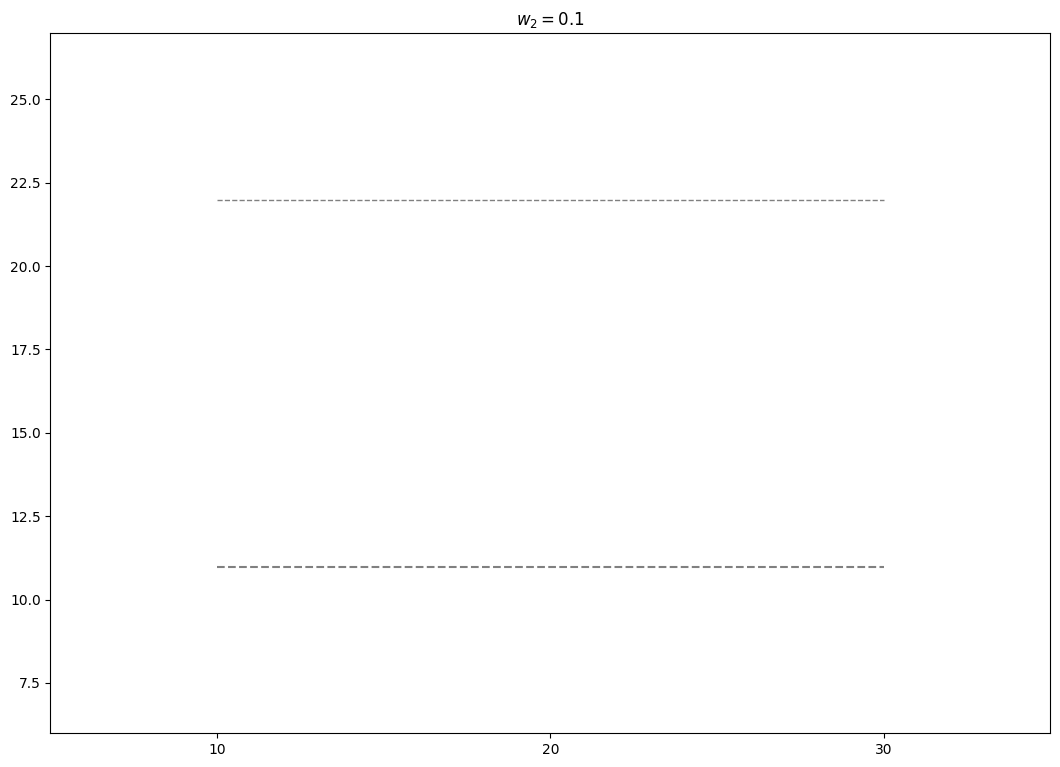

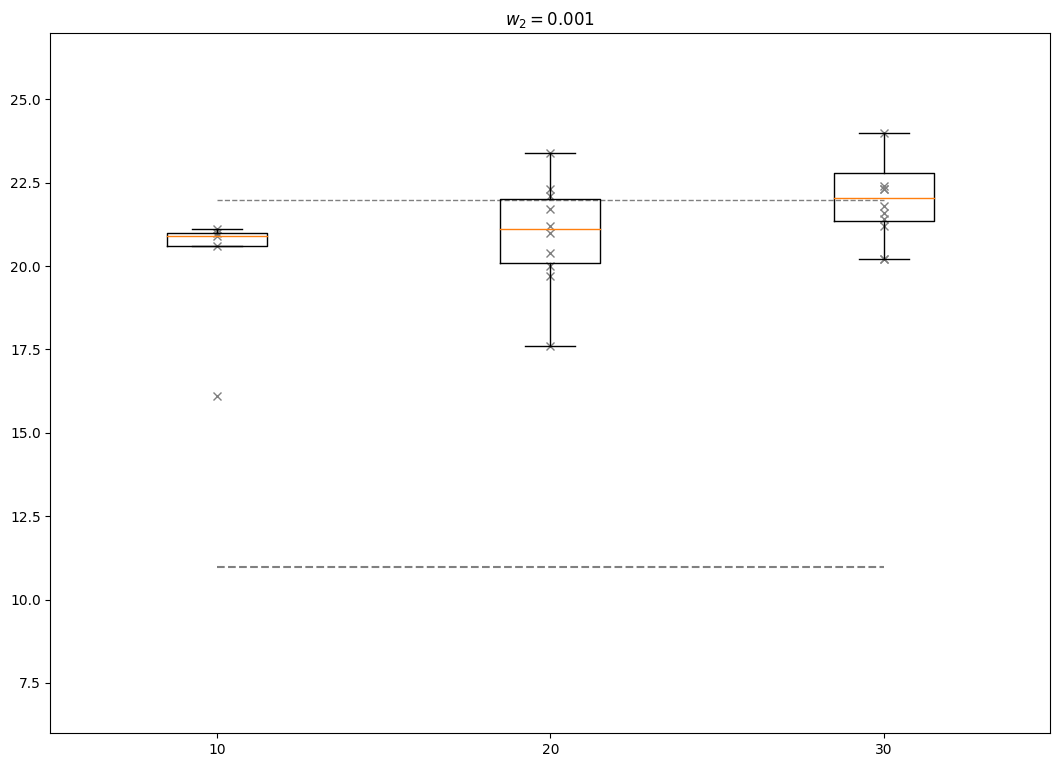

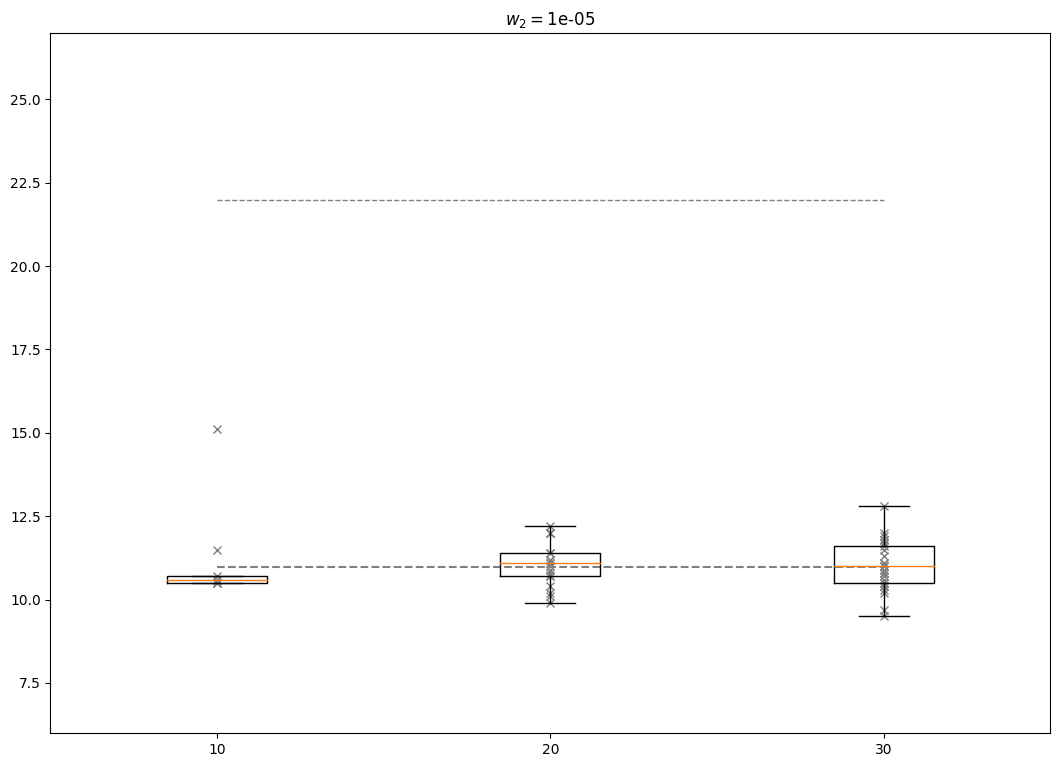

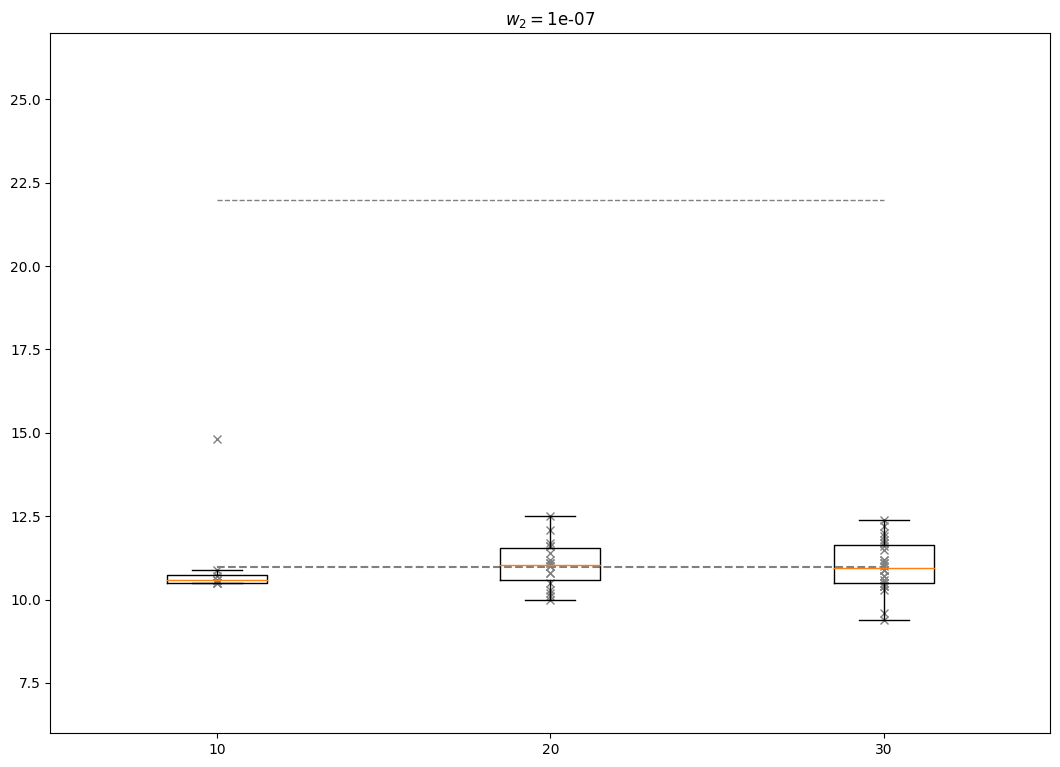

In [243]:
for iw in range(len(w2_array)):
    ydata = []
    fig = plt.figure(figsize =(10, 7))
    ax = fig.add_axes([0, 0, 1, 1])

    for i in range(len(results_xup1["periods"])):
        if len(results_xup1["periods"][i][iw]) != 0:
            ydata.append(results_xup1["periods"][i][iw])
            for dpoint in results_xup1["periods"][i][iw]:
                ax.plot(i+1, dpoint, marker="x", color="grey")
        else:
            ydata.append([0])

    #print(ydata)
            
    ax.boxplot(ydata, showfliers=False)
    ax.plot()
    ax.hlines(target_period, 1., 3., linestyle="--", color="gray")
    ax.hlines(2.*target_period, 1., 3., linestyle="--", color="gray", linewidth=1)
    ax.set_xticklabels(X_periods)
    ax.set_ylim(target_period-5, 2*target_period+5)
    ax.set_title(r"$w_2 = $" + "{}".format(w2_array[iw]))
    plt.show()
    fig.savefig("wc_xup1_" + str(iw) + ".png", bbox_inches='tight')

In [374]:
results_xdown = dict()
w2_array = [1e-2, 1e-3, 1e-4, 1e-5]
dt_array = [1e-1, 1e-2]

results_xdown["periods"] = [ [ None, None, None, None ], [ None, None, None, None ] ]
results_xdown["controls"] = [ [ None, None, None, None ], [ None, None, None, None ] ]

In [384]:
it = 1000
proms = [0.001, 0.003, 0.01, 0.03]
pr = np.arange(0,1000,100)

pind = 2
p = comp_points[pind]
print("--------------------------------")
print("POINT : ", p)

for idt in range(len(dt_array)):

    if idt not in [0]:
        continue

    dt = dt_array[idt]
    model.params.dt = dt
    int0 = 100
    if idt == 1:
        int0 = 1000
    duration = np.around(int0*dt + 6. * target_period,0)
    print("duration = ", duration)

    model.params.duration = duration
    zero_input = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
    zero_control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]

    model.params["exc_ext"] = zero_input + p[0]
    model.params["inh_ext"] = zero_input + p[1]
    model.run()
    model.params.exc_init = np.array([[ model.exc[0,-1] ]])
    model.params.inh_init = np.array([[ model.inh[0,-1] ]])

    for iw in range(len(w2_array)):

        if iw not in [3]:
            continue

        w2 =w2_array[iw]
        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), control_matrix = controlmat, )
        model_controlled.maximum_control_strength = maxstr
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_f"] = 1.
        model_controlled.weights["w_2"] = w2
        print("L2 cost weight = ", w2)

        if type(results_xdown["controls"][idt][iw]) != type(None):
            model_controlled.control = results_xdown["controls"][idt][iw]
            model_controlled.update_input()

        """
        model_controlled.optimize(0)
        for k in range(6):
            grad = model_controlled.compute_gradient()
            plt.plot(grad[0,0,:], label=str(k))
            model_controlled.optimize(it)
        
        plt.legend()
        plt.show()
        """

        model_controlled.optimize(it)

        results_xdown["periods"][idt][iw] = getperiods(model_controlled.get_xs()[0,0,int0:], proms[iw]) 
        results_xdown["controls"][idt][iw] = model_controlled.control.copy()

        #plot_oc_singlenode(duration, model.params.dt, model_controlled.get_xs(), target_period, model_controlled.control, )
        #        savepath=("./wc_ff_" + str(pind) + "_" + str(idt) + ".png") )

--------------------------------
POINT :  [3.0, 0.5]
duration =  76.0
Optimal control with target oscillation period
L2 cost weight =  1e-05
Compute control for a deterministic system
Cost in iteration 0: -0.13507182107989466
Cost in iteration 100: -0.13508223637766642
Cost in iteration 200: -0.1350925753094806
Cost in iteration 300: -0.1351029661166229
Cost in iteration 400: -0.13511329909973818
Cost in iteration 500: -0.13512379172320865
Cost in iteration 600: -0.13513420994265576
Cost in iteration 700: -0.13514472436851385
Cost in iteration 800: -0.13515522683161324
Cost in iteration 900: -0.13516567500548662
Final cost : -0.13517630608804423
[9.1, 13.600000000000001, 10.700000000000001]


--------------------------------
POINT :  [3.0, 0.5]
duration =  76.0
Optimal control with target oscillation period
L2 cost weight =  0.01
Compute control for a deterministic system
Cost in iteration 0: -2.331835021909958e-17
Converged in iteration 6 with cost -0.00024211449778965106
Final cost : -0.00024211449778965106


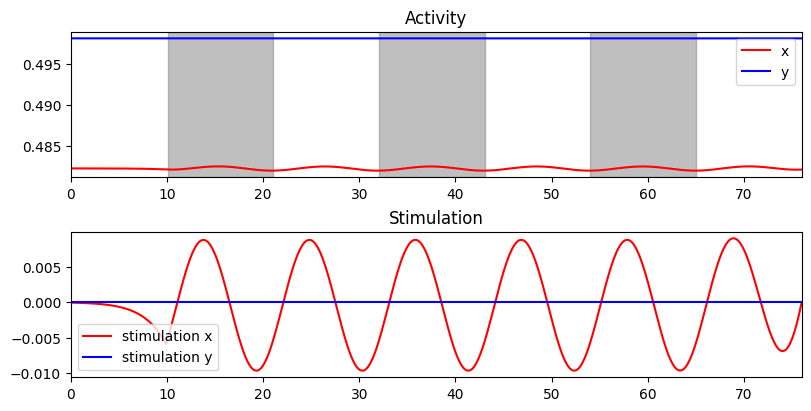

Optimal control with target oscillation period
L2 cost weight =  0.001
Compute control for a deterministic system
Cost in iteration 0: -2.331835021909958e-17
Converged in iteration 9 with cost -0.0025330025537471275
Final cost : -0.0025330025537471275


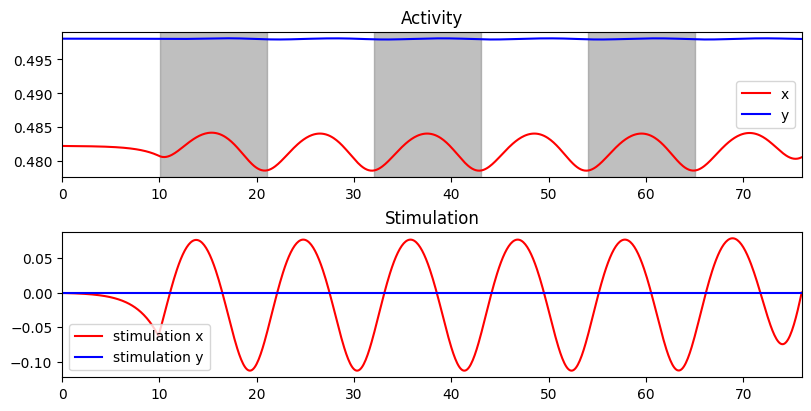

Optimal control with target oscillation period
L2 cost weight =  0.0001
Compute control for a deterministic system
Cost in iteration 0: -2.331835021909958e-17
Cost in iteration 10: -0.33762783851711353
Converged in iteration 17 with cost -0.3586397955857369
Final cost : -0.3586397955857369


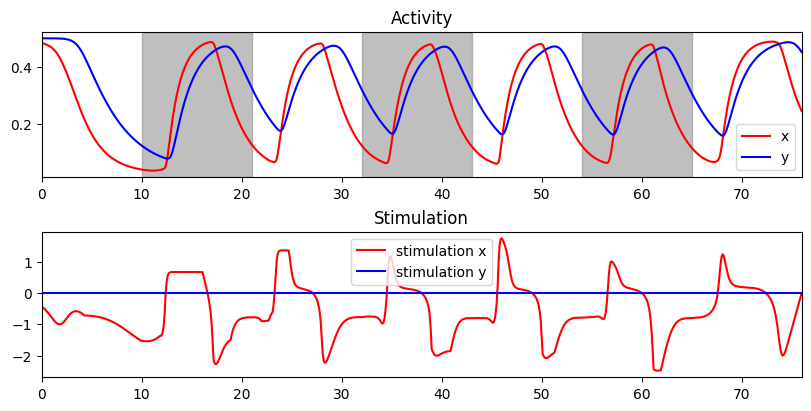

Optimal control with target oscillation period
L2 cost weight =  1e-05
Compute control for a deterministic system
Cost in iteration 0: -2.331835021909958e-17
Cost in iteration 10: -0.12890411653418357
Cost in iteration 20: -0.38437271977515663
Converged in iteration 24 with cost -0.3849069507342489
Final cost : -0.3849069507342489


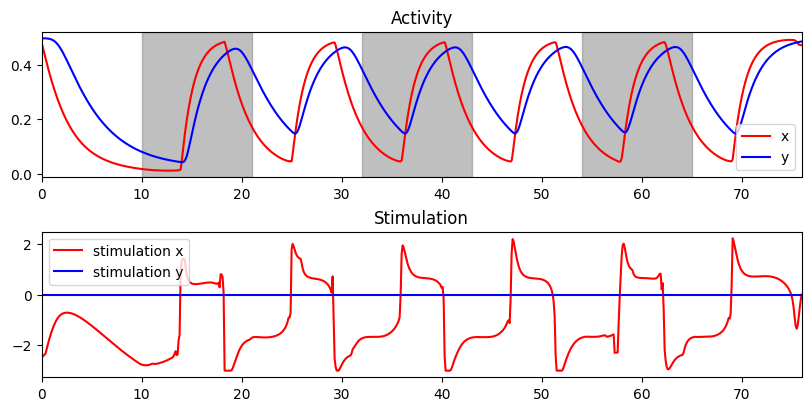

In [380]:
it = 40
proms = [0.001, 0.003, 0.01, 0.03]
pr = np.arange(0,100,10)

pind = 2
p = comp_points[pind]
print("--------------------------------")
print("POINT : ", p)

for idt in [0]:
    dt = dt_array[idt]
    model.params.dt = dt
    int0 = 100
    if idt == 1:
        int0 = 1000
    duration = np.around(int0*dt + 6. * target_period,0)
    print("duration = ", duration)

    model.params.duration = duration
    zero_input = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
    zero_control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]

    model.params["exc_ext"] = zero_input + p[0]
    model.params["inh_ext"] = zero_input + p[1]
    model.run()
    model.params.exc_init = np.array([[ model.exc[0,-1] ]])
    model.params.inh_init = np.array([[ model.inh[0,-1] ]])

    for iw in range(len(w2_array)):

        if iw not in [0,1,2,3]:
            continue

        w2 =w2_array[iw]
        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), control_matrix = controlmat, )
        model_controlled.maximum_control_strength = maxstr
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_f"] = 1.
        model_controlled.weights["w_2"] = w2
        print("L2 cost weight = ", w2)

        model_controlled.optimize(it)

        plot_oc_singlenode(duration, model.params.dt, model_controlled.get_xs(), target_period, model_controlled.control, )
        #        savepath=("./wc_ff_" + str(pind) + "_" + str(idt) + ".png") )

In [344]:
filehandler = open("results_xdown.pickle","wb")
pickle.dump(results_xdown,filehandler)

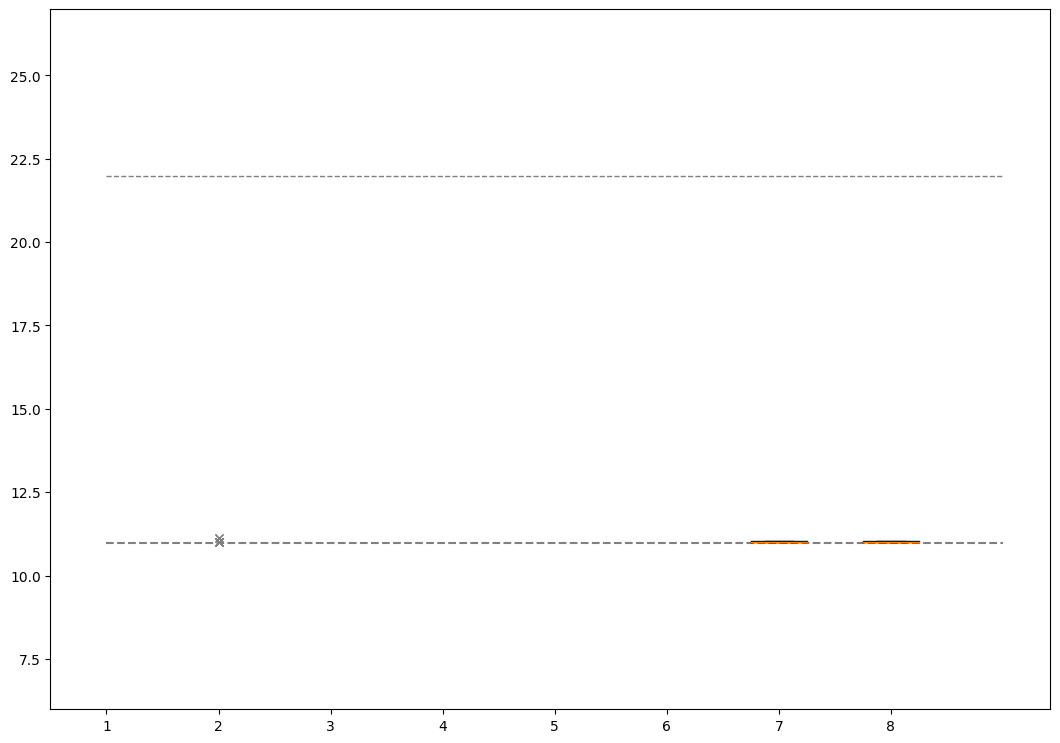

In [339]:
ydata = []
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])

for iw in range(len(w2_array)):
    for idt in range(len(dt_array)):

        if len(results_xdown["periods"][idt][iw]) != 0:
            ydata.append(results_xdown["periods"][i][iw])
            for dpoint in results_xdown["periods"][i][iw]:
                ax.plot(i+1, dpoint, marker="x", color="grey")
        else:
            ydata.append([0])

    #print(ydata)
            
ax.boxplot(ydata, showfliers=False)
ax.plot()
ax.hlines(target_period, 1., 9., linestyle="--", color="gray")
ax.hlines(2.*target_period, 1., 9., linestyle="--", color="gray", linewidth=1)
#ax.set_xticklabels(dt_array)
ax.set_ylim(target_period-5, 2*target_period+5)
#ax.set_title(r"$w_2 = $" + "{}".format(w2_array[iw]))
plt.show()
fig.savefig("wc_xdown_.png", bbox_inches='tight')